# Preprocessing

In [147]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
%autoreload 2

In [149]:
import torch

In [150]:
from src.vfm.connection import Connection
from src.vfm.preprocessor import Preprocessor
import pandas as pd
from src.utils.descriptive_utils import *
from src.vfm.model.physics.physics_informed import PhysicsInformedHybridModel
from src.utils import *
import matplotlib.pyplot as plt
import os

In [275]:
connection = Connection()
# Get client
client = connection.get_client()

In [276]:
df_all_wells = connection.get_data(client, wells=get_all_wells())
df_all_wells.columns

Index(['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test',
       'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm',
       'well_id'],
      dtype='object')

In [277]:
dependent_vars=get_depdendent_vars()
independent_vars=get_independent_vars()

In [278]:
preprocessor = Preprocessor()
df_all_wells_preprocessed = preprocessor.preprocess_timeseries(df=df_all_wells)
len(df_all_wells_preprocessed)

Preprocessing well W10... with columns ['whp', 'wht', 'dhp', 'dht', 'choke', 'dcp', 'qo_well_test', 'qg_well_test', 'qw_well_test', 'qo_mpfm', 'qg_mpfm', 'wc_mpfm', 'well_id']


218

In [279]:
summarize_null(df_all_wells_preprocessed)

qo_mpfm      0
qg_mpfm      0
qw_mpfm      0
well_code    0
dhp          0
dht          0
whp          0
wht          0
choke        0
dcp          0
well_id      0
wc_mpfm      0
time_idx     0
dtype: int64

In [280]:
df_all_wells_preprocessed["well_code"].unique()

array([0.])

In [281]:
df_train, df_val, df_test = get_random_train_test_split_per_well_with_order_preserved(df=df_all_wells_preprocessed, test_size=0.2)
len(df_train), len(df_val), len(df_test)

(157, 19, 42)

In [282]:
model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
model.fit(df=df_train, df_val=df_val)

[Validation] Residual RMSE = 0.1767


In [283]:
model.score_physics(df_test)

{'W10': {'qo': {'r2': 0.29247858531638293,
   'mae': 26.310524900089913,
   'rmse': 30.87146356000814,
   'mape (%)': 25.532129013240322,
   'mpe (%)': 9.613464049963365},
  'qw': {'r2': 0.8514923257795235,
   'mae': 3.831420511737394,
   'rmse': 5.5431688883688,
   'mape (%)': 79.00003056246952,
   'mpe (%)': 27.769673458589704},
  'qg': {'r2': 0.5929370040953981,
   'mae': 1973.7777536646395,
   'rmse': 2678.314506302364,
   'mape (%)': 11.204621956870318,
   'mpe (%)': -5.135319076307352},
  'wgr': {'r2': 0.7590166589769581,
   'mae': 0.0003219209297131963,
   'rmse': 0.0004941508815683241,
   'mape (%)': 104.70059948255239,
   'mpe (%)': 51.58424071700446},
  'gor': {'r2': -0.6146431698745871,
   'mae': 17.528743004755842,
   'rmse': 25.128372782068606,
   'mape (%)': 13.001424688656323,
   'mpe (%)': -9.056244331050689}}}

In [284]:
model.score_hybrid(df_test)

{'W10': {'qo': {'r2': 0.7298199183634455,
   'mae': 14.898683257021192,
   'rmse': 19.07717610317701,
   'mape (%)': 14.219366483670672,
   'mpe (%)': 2.066832126132219},
  'qw': {'r2': 0.9609825213765816,
   'mae': 2.109918968225168,
   'rmse': 2.841274954115503,
   'mape (%)': 50.79052626171544,
   'mpe (%)': -31.220539309566153},
  'qg': {'r2': 0.8935446836575406,
   'mae': 1028.0104035084198,
   'rmse': 1369.6652541652415,
   'mape (%)': 7.053896072527681,
   'mpe (%)': -0.454304124644296},
  'wgr': {'r2': 0.9560448402428415,
   'mae': 0.00014463818562797623,
   'rmse': 0.00021104302115047734,
   'mape (%)': 50.93385690242268,
   'mpe (%)': -31.11859600602655},
  'gor': {'r2': -0.1836244021364588,
   'mae': 16.033549412508066,
   'rmse': 21.51458837590546,
   'mape (%)': 11.952177894165462,
   'mpe (%)': 0.1368674251034099}}}

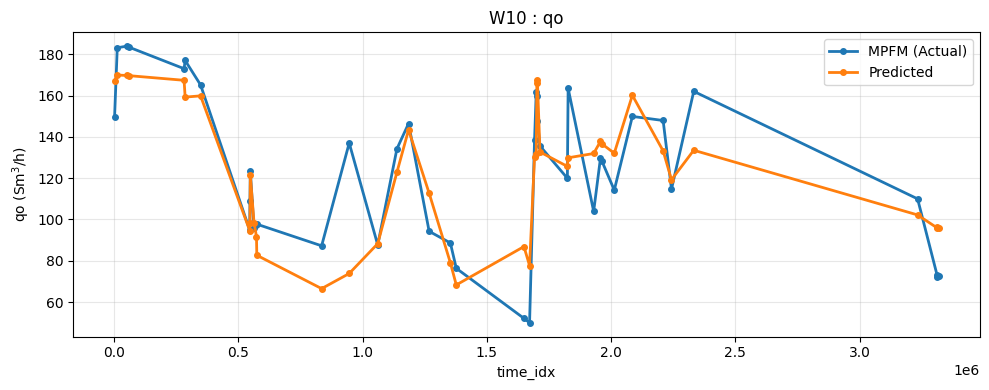

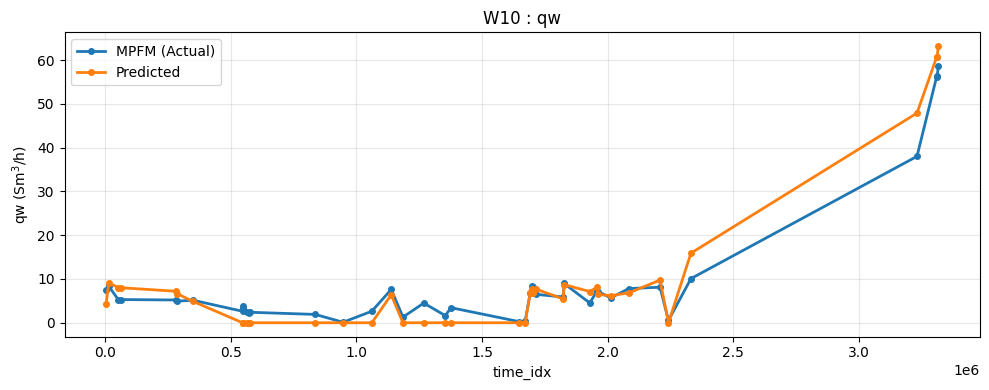

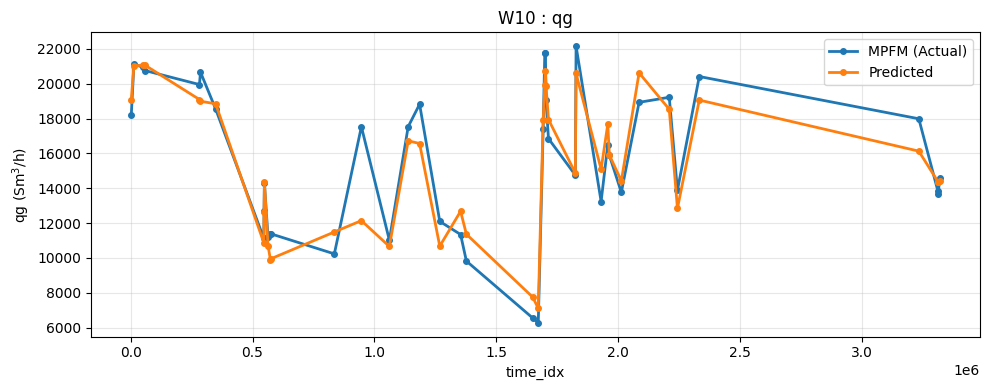

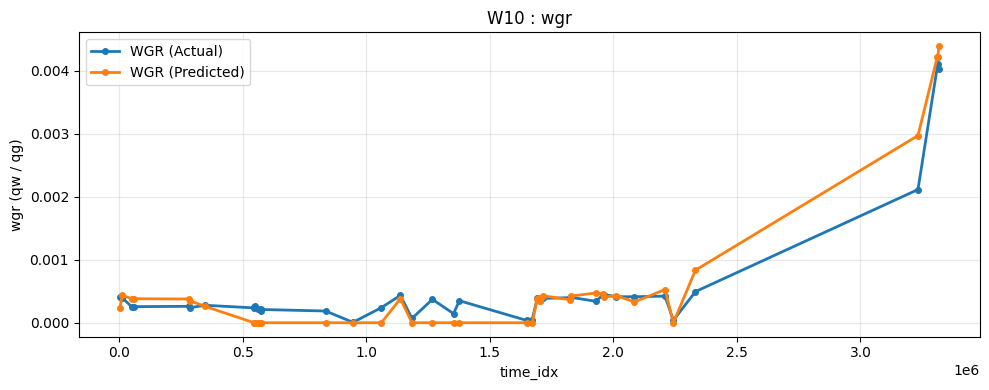

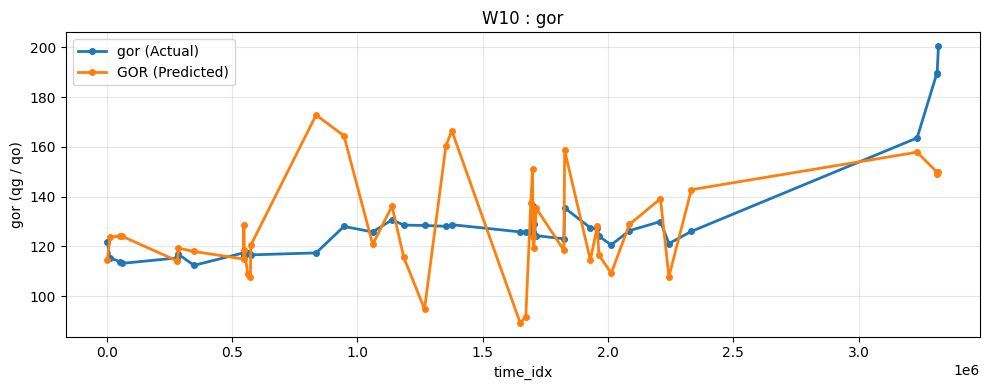

In [285]:
model.plot_predictions(df=df_test, time_col="time_idx", is_hybrid_model=True)

In [286]:
def lowo_with_partial_calibration(
    df,
    n_calibration_points=2,
):
    results = []

    for test_well in df["well_id"].unique():
        df_well = df[df["well_id"] == test_well]
        df_train_other = df[df["well_id"] != test_well]

        df_cal = df_well.iloc[:n_calibration_points]
        df_test = df_well.iloc[n_calibration_points:]

        df_train = pd.concat([df_train_other, df_cal])

        model = PhysicsInformedHybridModel(dependant_vars=dependent_vars, independent_vars=independent_vars)
        # model.phys_model.fit_pres = False
        model.fit(df_train)

        results.append({
            "well": test_well,
            "scores": model.hybrid_score(df_test)
        })

    return results


In [287]:
# lowo_with_partial_calibration(df=df_with_targets)